In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

### Load Our World in Data COVID dataset

In [6]:
# create data directory if it doesnt exist yet
if not 'data' in os.listdir():
    ! mkdir data

data_dir = './data/'

# clean data dir from old data (some sets are updated on a daily bases)
! rm data/*

owid_url = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv'

data = pd.read_csv(owid_url)

zsh:1: no matches found: data/*


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97389 entries, 0 to 97388
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   iso_code                               97389 non-null  object        
 1   continent                              92810 non-null  object        
 2   location                               97389 non-null  object        
 3   date                                   97389 non-null  datetime64[ns]
 4   total_cases                            93993 non-null  float64       
 5   new_cases                              93990 non-null  float64       
 6   new_cases_smoothed                     92975 non-null  float64       
 7   total_deaths                           83909 non-null  float64       
 8   new_deaths                             84065 non-null  float64       
 9   new_deaths_smoothed                    92975 non-null  float6

### Preparing the data

Now we want to do a similar analysis to Middelhoff (2020), for this we need for the countries we want to examine
1. the date of the first confirmed death. This will be the index date for the country
2. day 25 after the index date
   
When we have this we can appropriately compare the countries.

In [14]:
# convert date to datetime so we can perform min()
data['date'] = pd.to_datetime(data['date'])

In [99]:
countries = data['iso_code'].unique()
ctr_idx = pd.DataFrame(countries, columns=['iso_code'])

# iterate over countries, for each get rows with new deaths and find min date as index
for idx, ctr in enumerate(countries):
    data_ctr = data.loc[data['iso_code'] == ctr]
    new_deaths = data_ctr.loc[data_ctr['new_deaths'].notna()]
    if len(new_deaths) > 0:
        indices.append(min(new_deaths['date']))
    else:
        indices.append(pd.Timestamp('2018-01-01'))

# now we have new table that maps iso code to index date
ctr_idx['index_date'] = pd.Series(indices, dtype='datetime64[ns]')
ctr_idx.head()

,iso_code,index_date
0,AFG,2020-03-22
1,OWID_AFR,2020-02-13
2,ALB,2020-03-11
3,DZA,2020-03-12
4,AND,2020-03-22


Now we want to find the number of deaths on day 25 *after* the index date, so we can express deaths
in the future as a percentage of this number:

In [146]:
deaths = []

# add 25 days to first death date and find total deaths on this date for each country (fill with NaN if zero)
for ctr in countries:
    day25 = ctr_idx.loc[ctr_idx['iso_code'] == ctr]['index_date'] + pd.Timedelta(25, 'D')
    day25 = pd.Timestamp(day25.values[0])
    d25_deaths = data.loc[(data['iso_code'] == ctr) & (data['date'] == day25)]['total_deaths']
    if len(d25_deaths) > 0:
        deaths.append(d25_deaths.values[0])
    else:
        deaths.append('NaN')

ctr_idx['deaths_day25'] = pd.Series(deaths, dtype='float64')
ctr_idx.head()

,iso_code,index_date,deaths_day25
0,AFG,2020-03-22,30.0
1,OWID_AFR,2020-02-13,1.0
2,ALB,2020-03-11,20.0
3,DZA,2020-03-12,173.0
4,AND,2020-03-22,33.0


### First visualization and inspection

Let's look into our newly created table to find some interesting information.
We plot the index date against the reported deaths on day 25 after the first death.
To simplify analysis, we only select a number of countries, namely ESP, ITA, GBR, GER, SWE, CHN, PRT, USA, BEL, KOR, TWN.

In [199]:
ctr_of_interest = ['ESP', 'ITA', 'GBR', 'DEU', 'SWE', 'CHN', 'PRT', 'USA', 'BEL', 'KOR', 'TWN']

No handles with labels found to put in legend.


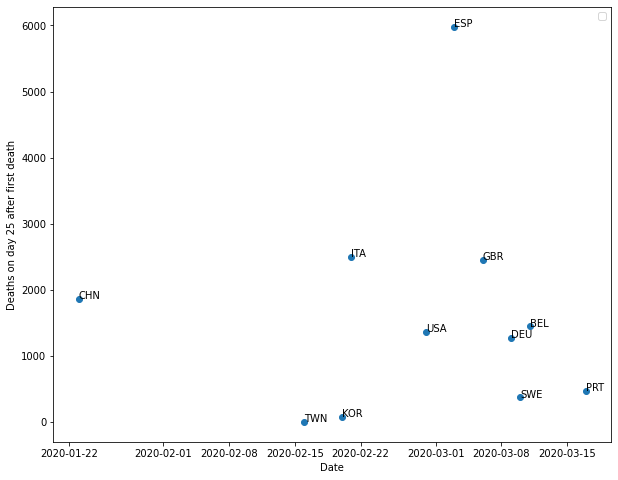

In [200]:
df_plot = ctr_idx.loc[ctr_idx['iso_code'].isin(ctr_of_interest)]

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_plot["index_date"], df_plot["deaths_day25"])
ax.set_ylabel("Deaths on day 25 after first death")
ax.set_xlabel("Date")
plt.legend()

for i, txt in zip(df_plot.index, df_plot['iso_code']):
    ax.annotate(txt, (df_plot["index_date"][i], df_plot["deaths_day25"][i]))

#plt.savefig('deaths_cases_EU')

Here we can see how "hard" the countries were hit by the pandemic and how well they responded to the first outbreak.



### Next step: make data of countries comparable by removing difficulties (according to Middelhoff & Rosendaal)


  - The different scales of cases/deaths (they argue even deaths/100k is not appropriate. The idea is to express the **cumulative deaths as % of deaths on day 25 after the first recorded death** in each country.

  
  - The time delay: Countries are hit by pandemic on different dates, makes comparison difficult. Thus, we move away from the actual *date*, and consider the **days after first recorded death**. This layers the curves of deaths on top of each other, easy for comparison.

In [286]:
# select our countries of interest from the complete table
# and the table containing index dates and day25 deaths 

data_n = data.loc[data['iso_code'].isin(ctr_of_interest)]

idx_deaths = ctr_idx.loc[ctr_idx['iso_code'].isin(ctr_of_interest)].sort_values(['iso_code'])
idx_deaths = idx_deaths.reset_index()

In [298]:
# we want to look 150 days after the first death
timedelta = pd.Timedelta(150, 'D')

# find the index date and the number of deaths on day 25
ita_day25 = idx_deaths.loc[idx_deaths['iso_code'] == 'ITA']['deaths_day25'].values[0]
ita_index_date = idx_deaths.loc[idx_deaths['iso_code'] == 'ITA']['index_date'].values[0]

# list the first 150 days after index
ita = data_n.loc[(data_n['iso_code'] == 'ITA') & (data_n['date'] >= ita_index_date) 
                 & (data_n['date'] < ita_index_date + timedelta)]
ita = ita.reset_index()

# same for DEU, USA

ger_day25 = idx_deaths.loc[idx_deaths['iso_code'] == 'DEU']['deaths_day25'].values[0]
ger_index_date = idx_deaths.loc[idx_deaths['iso_code'] == 'DEU']['index_date'].values[0]

ger = data_n.loc[(data_n['iso_code'] == 'DEU') & (data_n['date'] >= ger_index_date) 
                 & (data_n['date'] < ger_index_date + timedelta)]
ger = ger.reset_index()

usa_day25 = idx_deaths.loc[idx_deaths['iso_code'] == 'USA']['deaths_day25'].values[0]
usa_index_date = idx_deaths.loc[idx_deaths['iso_code'] == 'USA']['index_date'].values[0]

usa = data_n.loc[(data_n['iso_code'] == 'USA') & (data_n['date'] >= usa_index_date) 
                 & (data_n['date'] < usa_index_date + timedelta)]
usa = usa.reset_index()

In [317]:
tables = []

for ctr in ctr_of_interest:
    day25 = idx_deaths.loc[idx_deaths['iso_code'] == ctr]['deaths_day25'].values[0]
    index_date = idx_deaths.loc[idx_deaths['iso_code'] == ctr]['index_date'].values[0]


    table = data_n.loc[(data_n['iso_code'] == ctr) & (data_n['date'] >= index_date) 
                 & (data_n['date'] < index_date + timedelta)]
    
    table['percent_deaths'] = table['total_deaths'] / day25 * 100
    table = table.reset_index()
    tables.append([ctr, table])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Days after first death per country')

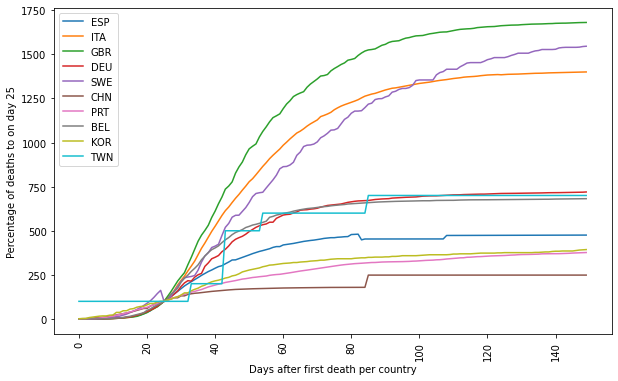

In [319]:
plt.figure(figsize=(10,6))

for ctr, table in tables:
    if ctr == 'USA':
        continue
    plt.plot(table.index, table['percent_deaths'], label=ctr)
#plt.plot(ger.index, ger['total_deaths'] / ger_day25 * 100, label='Germany')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Percentage of deaths to on day 25')
plt.xlabel('Days after first death per country')

Text(0.5, 0, 'Days after first death per country')

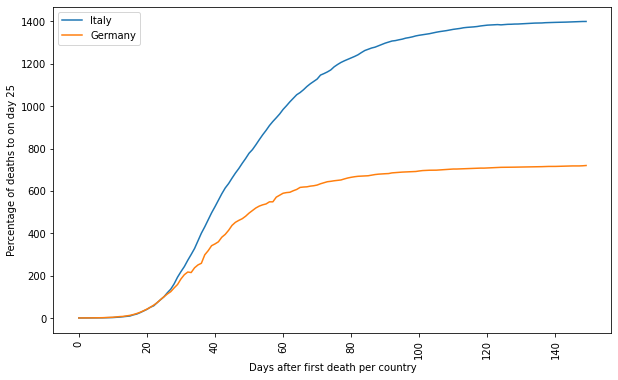

In [320]:
plt.figure(figsize=(10,6))
plt.plot(ita.index, ita['total_deaths'] / ita_day25 * 100, label='Italy')
plt.plot(ger.index, ger['total_deaths'] / ger_day25 * 100, label='Germany')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Percentage of deaths to on day 25')
plt.xlabel('Days after first death per country')

Text(0.5, 0, 'Days after first death per country')

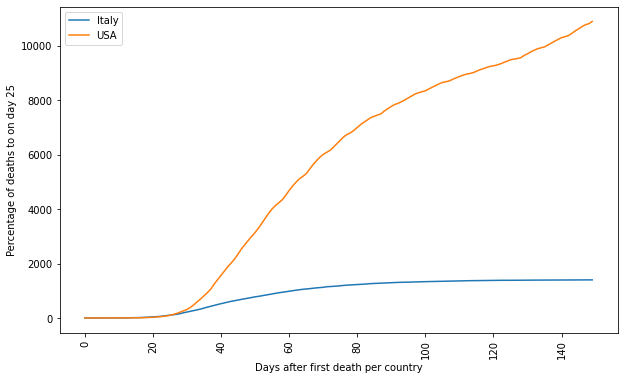

In [321]:
plt.figure(figsize=(10,6))
plt.plot(ita.index, ita['total_deaths'] / ita_day25 * 100, label='Italy')
plt.plot(usa.index, usa['total_deaths'] / usa_day25 * 100, label='USA')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('Percentage of deaths to on day 25')
plt.xlabel('Days after first death per country')